# Compare query recall
In which we compare the recall of gold toponym IDs within the candidate sets generated by (1) GeoNames black-box queries and (2) name-matching on the GeoNames database.

In [1]:
import pandas as pd

In [37]:
geonames_queries = pd.read_csv('../../data/mined_tweets/GeoCorpora/geocorpora_geonames_query_results.tsv', 
                               sep='\t', index_col=False, encoding='utf-8')
names_queries = pd.read_csv('../../data/mined_tweets/GeoCorpora/geocorpora_names_query_results.tsv', 
                            sep='\t', index_col=False, encoding='utf-8')
# convert unicode to str
geonames_queries.loc[:, 'query'] = geonames_queries.loc[:, 'query'].apply(lambda x: x.encode('utf-8') if type(x) is unicode else x)
names_queries.loc[:, 'query'] = names_queries.loc[:, 'query'].apply(lambda x: x.encode('utf-8') if type(x) is unicode else x)

In [34]:
gold_data = pd.read_csv('../../data/mined_tweets/GeoCorpora/geocorpora.tsv', sep='\t', index_col=False, usecols=['text', 'geoNameId'])
gold_data.fillna('', inplace=True)
gold_data = gold_data[(gold_data.loc[:, 'geoNameId'] != '') & (gold_data.loc[:, 'geoNameId'] != 'noGeonameId')]
# convert IDs to int
gold_data.loc[:, 'geoNameId'] = gold_data.loc[:, 'geoNameId'].astype(int)
gold_data.rename(columns={'geoNameId' : 'geonames_ID'}, inplace=True)

In [23]:
print('%d unique queries/%d total queries'%(gold_data.loc[:, 'text'].nunique(), gold_data.shape[0]))
gold_data.head()

1309 unique queries/3100 total queries


,text,geonames_ID
0,Rivers,2324433
1,Nigeria,2328926
2,Nigeria,2328926
3,Alabama,4829764
4,Libya,2215636


## Overall coverage
How many of the original queries does each method catch?

In [24]:
geonames_unique = geonames_queries.loc[:, 'query'].nunique()
name_unique = names_queries.loc[:, 'query'].nunique()
gold_unique = gold_data.loc[:, 'text'].nunique()
print('GeoNames query covers %d/%d queries'%(geonames_unique, gold_unique))
print('names query covers %d/%d queries'%(name_unique, gold_unique))

GeoNames query covers 1288/1309 queries
names query covers 1313/1309 queries


Oh OK! The names queries actually cover the whole of GeoCorpora.

But how many of the queries contain the gold ID?

In [57]:
from __future__ import division
geonames_recall = 0.
geonames_OOV_data = []
names_recall = 0.
names_OOV_data = []
# N = 0.
N = gold_data.groupby(['geonames_ID', 'text']).count().shape[0]
for (q_str, q_id), q_data in gold_data.groupby(['text', 'geonames_ID']):
    q_geonames_ids = geonames_queries[geonames_queries.loc[:, 'query'] == q_str].loc[:, 'geonames_ID'].values.tolist()
    q_names_ids = names_queries[names_queries.loc[:, 'query'] == q_str].loc[:, 'geonames_ID'].values.tolist()
    if(q_id in q_geonames_ids):
        geonames_recall += 1
    else:
        geonames_OOV_data.append([q_id, q_str])
    if(q_id in q_names_ids):
        names_recall += 1
    else:
        names_OOV_data.append([q_id, q_str])
geonames_recall /= N
names_recall /= N
print('GeoNames recall = %.3f'%(geonames_recall))
print('names recall = %.3f'%(names_recall))

GeoNames recall = 0.709
names recall = 0.724


So it seems like the name matching has a better recall, which suggests that we should be using that for our candidates.

What about the distribution of candidates?

If one of the methods is producing too many candidates per query, then the ranking might be harder.

In [73]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
geonames_candidate_counts = geonames_queries.groupby('query').apply(lambda x: x.shape[0])
names_candidate_counts = names_queries.groupby('query').apply(lambda x: x.shape[0])

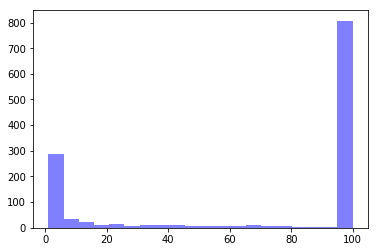

In [76]:
plt.hist(geonames_candidate_counts, bins=20, color='b', alpha=0.5)
plt.show()

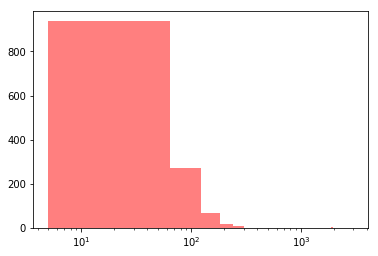

In [80]:
plt.hist(names_candidate_counts, bins=50, color='r', alpha=0.5)
plt.xscale('log')
plt.show()

Oh yikes. So basically the names-matching gets a better recall because it tends to include way more candidates than the GeoNames matching.

TODO: implement actual name-matching sieve so that we don't get stuck with a bunch of irrelevant stuff.

## Check name-matching sieve
We implemented the sieve in `scripts/data_processing/query_geonames_all_names.py`, so now let's check on the recall.

In [156]:
query_results_full = pd.read_csv('../../data/mined_tweets/GeoCorpora/geocorpora_names_query_results_full.tsv', sep='\t', index_col=False)
# get rid of duplicates
query_results_full.drop_duplicates(['query', 'geonames_ID'], inplace=True)

In [157]:
print('%d queries'%(query_results_full.shape[0]))
query_results_full.head()

34783 queries


,query,geonames_ID,match
0,14th street bridge,4138865,approx
1,14th street bridge,4137581,approx
2,312 MARKET ST,8645171,approx
3,312 MARKET ST,7676840,approx
4,312 MARKET ST,6948418,approx


In [158]:
from data_helpers import load_geocorpora_data
geocorpora = load_geocorpora_data()
geocorpora.head()

,tweet_id_str,char_position,text,geoNameId,toponym,country_code,longitude,latitude,surrogate_geojson,uncertain_semantics,vague,overlapping_ambiguous,non_overlapping_ambiguous,not_in_geonames
feature_id,,,,,,,,,,,,,,
1,557916969433718785,10,Rivers,2324433,Rivers State,NG,6.82766,4.74974,NaN,True,NaN,NaN,NaN,NaN
2,557916969433718785,85,Nigeria,2328926,Federal Republic of Nigeria,NG,8.00000,10.00000,NaN,NaN,NaN,NaN,NaN,NaN
3,557916969433718785,99,Nigeria,2328926,Federal Republic of Nigeria,NG,8.00000,10.00000,NaN,NaN,NaN,NaN,NaN,NaN
4,517722122357964800,32,Alabama,4829764,Alabama,US,-86.75026,32.75041,NaN,NaN,NaN,NaN,NaN,NaN
5,489545428804055041,41,Libya,2215636,Libya,LY,17.00000,28.00000,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# check coverage
query_hits = 0.
gold_topo_hits = 0.
unique_queries = geocorpora.loc[:, 'text'].unique()
N = len(unique_queries)
N_gold = geocorpora.groupby(['text', 'geoNameId']).apply(lambda x: x.shape[0]).shape[0]
for q_str in unique_queries:
    relevant_queries = query_results_full[query_results_full.loc[:, 'query'] == q_str]
    if(relevant_queries.shape[0] > 0):
        query_hits += 1
    gold_ids = geocorpora[geocorpora.loc[:, 'text'] == q_str].loc[:, 'geoNameId'].values
    gold_queries = relevant_queries[relevant_queries.loc[:, 'geonames_ID'].apply(lambda x: x in gold_ids)]
    gold_topo_hits += gold_queries.shape[0]
query_recall = query_hits / N
query_gold_recall = gold_topo_hits / N

In [160]:
print('%.3f query recall'%(query_recall))
print('%.3f query gold recall'%(query_gold_recall))

0.793 query recall
0.716 query gold recall


This gold recall is still not great! What are we missing?

In [161]:
from data_helpers import load_simplified_geonames_data
geonames_data = load_simplified_geonames_data()
geonames_data.head()

,geonames_ID,name,alternate_names,latitude,longitude,feature_class,feature_code,country,population,alternate_name_count
0,2986043,Pic de Font Blanca,"Pic de Font Blanca,Pic du Port",42.64991,1.53335,T,PK,AD,0,2
1,2994701,Roc Mélé,"Roc Mele,Roc Meler,Roc Mélé",42.58765,1.74028,T,MT,AD,0,3
2,3007683,Pic des Langounelles,Pic des Langounelles,42.61203,1.47364,T,PK,AD,0,1
3,3017832,Pic de les Abelletes,"Pic de la Font-Negre,Pic de la Font-Nègre,Pic de les Abelletes",42.52535,1.73343,T,PK,AD,0,3
4,3017833,Estany de les Abelletes,"Estany de les Abelletes,Etang de Font-Negre,Étang de Font-Nègre",42.52915,1.73362,H,LK,AD,0,3


In [162]:
# view all alternate names
for q_str in unique_queries:
    relevant_queries = query_results_full[query_results_full.loc[:, 'query'] == q_str]
    gold_ids = set(geocorpora[geocorpora.loc[:, 'text'] == q_str].loc[:, 'geoNameId'].unique())
    gold_queries = relevant_queries[relevant_queries.loc[:, 'geonames_ID'].isin(gold_ids)]
    if(gold_queries.shape[0] == 0):
        print('query %s has %d relevant queries and is missing gold topo %s'%
              (q_str, relevant_queries.shape[0], str(gold_ids)))
        gold_geonames = geonames_data[geonames_data.loc[:,'geonames_ID'].isin(gold_ids)]
        print('gold data')
        for g in gold_ids:
            g_data = gold_geonames[gold_geonames.loc[:, 'geonames_ID'] == g].iloc[0, :].fillna('', inplace=False)
            g_names = [g_data.loc['name']] + unicode(g_data.loc['alternate_names']).split(',')
            print('%d,%s'%(g, ','.join(g_names)))
        if(relevant_queries.shape[0] > 0):
            print('relevant queries')
            print(relevant_queries)

query African Region has 0 relevant queries and is missing gold topo set([6255146])
gold data
6255146,Africa,Aafrika,Affrica,Africa,Afrihkka,Afrihkká,Afrika,Afrikka,Afriko,Afrique,Afryka,Afríka,Aphrike,Chau Phi,Châu Phi,afrika,afryqa,afryqya,afurika,an Afraic,apeulika,el Continente Negro,fei zhou,Àfrica,África,Āfrika,Αφρική,Африка,אפריקה,أفريقيا,افریقا,अफ़्रीका,แอฟริกา,アフリカ,非洲,아프리카
query Northcourt road comm. centre has 0 relevant queries and is missing gold topo set([2657780])
gold data
2657780,Abingdon,AEbbandun,Abindonia,Abingdon,Abingdon i Oxfordshire,Abingdon-on-Thames,Abingdonas,Abingdun,abindon=on=temuzu,abyngdn  aksfwrdshr,aebingdeon-ontemseu,tai wu shi he pan a bin dun,Æbbandūn,Абингдон,Абингдън,ابینگدن، آکسفوردشر,ایبینگڈن-آن-ٹیمز,アビンドン＝オン＝テムズ,泰晤士河畔阿賓頓,애빙던온템스
query Leipzig has 7 relevant queries and is missing gold topo set([3305800])
gold data
3305800,Direktionsbezirk Leipzig,Direktionsbezirk Leipzig,District de Leipzig,Lipsia
relevant queries
         query  geonames_ID   ma

query Imperial College has 0 relevant queries and is missing gold topo set([10376997])
gold data
10376997,Kensington Gardens,
query Nyaho Clinic has 0 relevant queries and is missing gold topo set([2306104])
gold data
2306104,Accra,ACC,Aakra,Aakrá,Accra,Acra,Akara,Akkr,Akkra,Akkrae,Akra,Akrao,Akʻra,Gorad Akra,Nkran,a ke la,akara,akeula,akra,akura,xak kra,yەkra,΄Aκκρα,Άκκρα,Аккрæ,Аккра,Акра,Горад Акра,Աքրա,אקרא,אקרה,آکرا,أكرا,ئەکرا,اكرا,اکرا,عکرہ,अक्रा,आक्रा,আক্রা,ਅਕਰਾ,ଆକ୍ରା,அக்ரா,അക്ര,อักกรา,ཨ་ཁ་ར།,အက်ခရာမြို့,აკრა,አክራ,アクラ,阿克拉,아크라
query Urumia has 0 relevant queries and is missing gold topo set([121801])
gold data
121801,Orūmīyeh,OMH,Orumiyeh,Orūmīyeh,Ourmia,Reza'iyeh,Rezaeyeh,Rezaiyye,Rezâiyye,Rezā’īyeh,Rizaiyeh,Rizāiyeh,Urmia,Urmija,Urmiya,Urmiye,Urmía,Urumija,Urumiyeh,Urūmiyeh,arwmyh,arwmyt,shhrstan arwmyh,Úrmia,Ûrmiye,Урмия,Урумия,אורמיה,أرومية,ارومیه,ارومیّه,شهرستان ارومیه,ܐܘܪܡܝܐ
query Bazar has 73 relevant queries and is missing gold topo set([121801])
gold data
121801,Orūmīyeh,O

gold data
4612762,Chapman Highway Shopping Center,
query Tornado Tower has 0 relevant queries and is missing gold topo set([290030])
gold data
290030,Doha,Ad Dawha,Ad Dawhah,Ad Dawḩa,Ad Dawḩah,Ad Doha,Ad Dowhah,Ad-Dauha,Ad-Dawhah,Ad-Dawḩah,DOH,Daeuha,Dauha,Dauhá,Dawha,Dawhat al Qatar,Dawḥa,Dawḩat al Qaţar,Dewhe,Do'ha,Doh,Doha,Doho,Dokha,Dokhae,Dokho,Dooxa,Doʻha,Doḥa,Duoha,Däuha,Gorad Dokha,Ntocha,aaldawhat,aldwhh,aldwht,deaha,do ha,doha,dohara,duo ha,dwhh,toka,Ντόχα,Горад Доха,Дохæ,Доха,Дохо,Доҳа,Доһа,Դոհա,דאכא,דוחא,דוחה,الدوحة,الدوحه,اَلدَّوْحَة,دوحه,دوحہ,دوحە,دوھا,دەوحە,दोहा,দোহা,দোহার,ਦੋਹਾ,தோகா,ದೊಹಾ,ദോഹ,โดฮา,དྷོ་ཧ།,ဒိုဟာမြို့,დოჰა,ዶሃ,ドーハ,多哈,도하
query Burj Doha has 0 relevant queries and is missing gold topo set([290030])
gold data
290030,Doha,Ad Dawha,Ad Dawhah,Ad Dawḩa,Ad Dawḩah,Ad Doha,Ad Dowhah,Ad-Dauha,Ad-Dawhah,Ad-Dawḩah,DOH,Daeuha,Dauha,Dauhá,Dawha,Dawhat al Qatar,Dawḥa,Dawḩat al Qaţar,Dewhe,Do'ha,Doh,Doha,Doho,Dokha,Dokhae,Dokho,Dooxa,Doʻha,Doḥa,Duoha,Däuha,Gorad Dokha,Ntocha,

       query  geonames_ID   match
2486  Avalon      9172949  approx
2487  Avalon      6208272  approx
2488  Avalon      3035768  approx
2489  Avalon      9265444  approx
2490  Avalon      6214840  approx
2491  Avalon      6247571  approx
2492  Avalon      4180591  approx
2493  Avalon      6220870  approx
2494  Avalon      6244873  approx
2495  Avalon      4141289  approx
2496  Avalon      4141126  approx
2497  Avalon      4180592  approx
2498  Avalon      6218987  approx
2499  Avalon     10232209  approx
2500  Avalon      8816156   exact
2501  Avalon      4180594  approx
2502  Avalon      5888484  approx
2503  Avalon      4315208  approx
2504  Avalon      4315209  approx
2505  Avalon      4347609  approx
2506  Avalon      4347610  approx
2507  Avalon      4375385  approx
2508  Avalon      4416708  approx
2509  Avalon      4500579  approx
2510  Avalon      4505605  approx
2511  Avalon      4505608  approx
2512  Avalon      4519901  approx
2513  Avalon      4671755  approx
2514  Avalon  

gold data
285094,Al Ḩaram ash Sharīf,Al Haram,Al Haram ash Sharif,Al Ḩaram,Al Ḩaram ash Sharīf,El Haram esh Sharif,Explanada del Templo,Haram esh Sharif,Temple Area,The Noble Sanctuary
relevant queries
              query  geonames_ID   match
53552  Temple Mount     11258705  approx
53553  Temple Mount      2728845  approx
query Donetsk airport has 0 relevant queries and is missing gold topo set([6300953])
gold data
6300953,Donetsk International Airport,DOK,Donetsk International Airport,Donetsk Sergey Prokofiev International Airport,Mizhnarodnij aeroport "Donec'k,UKCC,Міжнародний аеропорт "Донецьк
query Ukrainian has 0 relevant queries and is missing gold topo set([690791])
gold data
690791,Ukraine,'Iukuleini,An Ucrain,An Úcráin,Ikerene,Ikrɛni,Lukrayaen,Lukrayän,Oekraine,Oekraïne,Okraina,Orileede Ukarini,Orílẹ́ède Ukarini,Oucrinne,Oukrania,Owkraina,U-crai-na,U-crai-na (Ukraine),Ucraegna,Ucraina,Ucraina - Ukraina,Ucrania,Ucrayena,Ucraína,Ucraína - Україна,Ucraïna,Ucràina,Ucrânia,Ucrægna

gold data
5506956,Las Vegas,Campi,Gorad Las-Vegas,LAS,Las Vegas,Las Vegas Mission,Las Vegas Ranch,Las Vegasas,Las Venkas,Las-Vegas,Las-Veqas,Lasvegasa,Lasvegaso,Los Vegas,Lungsod ng Las Vegas,McWilliamstown,Naʼazhǫǫsh Hátsoh,Old Town,Piigisi,Ragtown,Vegas,Westside,la si wei jia si,las fyghas,las vegas,las vekas,las veygas,las weka s,las wgas,las wygas  nywaڈa,las-vegasi,lasa bhegasa,lasa vegasa,lasa vhegasa,laseubegaseu,laseubeigeoseu,lʼs wgʼs,rasubegasu,Λας Βέγκας,Горад Лас-Вегас,Лас Вегас,Лас-Вегас,Լաս Վեգաս,לאס וגאס,לאס וועגאס,لاس فيغاس,لاس وگاس,لاس ویگاس، نیواڈا,لاس‌وقاس,लास वेगास,लास व्हेगस,লাস ভেগাস,ਲਾਸ ਵੇਗਸ,લાસ વેગાસ,லாஸ் வேகஸ்,లాస్ వెగాస్,ലാസ് വെയ്ഗസ്,ลาสเวกัส,လပ်ဗီးဂပ်စ်မြို့,ლას-ვეგასი,ላስ ቬጋስ,ラスベガス,拉斯維加斯,拉斯维加斯,라스베가스,라스베이거스
relevant queries
                 query  geonames_ID   match
27977  Red Rock Canyon      5436054  approx
27978  Red Rock Canyon      5436053  approx
27979  Red Rock Canyon      5747835   exact
27980  Red Rock Canyon      5707726   exact
27981  Red Rock Cany

gold data
7729885,Western Africa,Africa Occidental,Africa Ocidental,Africa occidentale,Afrique de l'Ouest,Westafrika,Zakhidna Afrika,Zapadnaja Afrika,ghrb afryqya,xiafurika,África Occidental,África Ocidental,Западная Африка,Західна Африка,غرب أفريقيا,西アフリカ
query St. Louis County has 0 relevant queries and is missing gold topo set([4407074])
gold data
4407074,Saint Louis County,Comte de Saint Louis,Comté de Saint Louis
query UGA has 24 relevant queries and is missing gold topo set([4227985])
gold data
4227985,University of Georgia,Franklin College,Franklin College of Arts and Sciences,Georgian yliopisto,Universidad de Georgia,Universidade da Georgia,Universidade da Geórgia,Universita della Georgia,Universitas Georgia,Universitas Georgiae,Universitat de Georgia,Universitat de Geòrgia,Universitato de Georgio,Universite de Georgie,Universitet Dzhordzhii,University of Georgia,Università della Georgia,Université de Géorgie,Univerzitet u Dzordziji,Univerzitet u Džordžiji,danshgah jwrjya,jojia

query Jammu & Kashmir has 0 relevant queries and is missing gold topo set([1269320])
gold data
1269320,State of Jammu and Kashmīr,Cachemire,JK,Jammu agus an Chaismir,Jammu agus an Chaismír,Jammu and Kashmir,Jammu and Kashmīr,Jammu og Kashmir,Jammu-et-Cachemire,Kashmir,Kashmīr,State of Jammu and Kashmir,State of Jammu and Kashmīr,jam'mu aura kasmira,jvama ta kesira,جموں و کشمیر,जम्मू और कश्मीर,ज्वम त॒ कॅशीर
query New Hanover has 8 relevant queries and is missing gold topo set([4481757])
gold data
4481757,New Hanover County,Comitatul New Hanover,Comte de New Hanover,Comté de New Hanover,Condado de New Hanover,Condado han New Hanover,Contea di New Hanover,Hrabstwo New Hanover,N'ju-Ganover,N'ju-Khanover,New Hanover Kun,New Hanover Kūn,New Hanover konderria,New Hanover megye,Nju Khanovur,Okrug NJu Khanover,Quan New Hanover,Quận New Hanover,mqatʿt nywhanwfr,ni'u hyanobhara ka'unti,nyuhanoba jun,shhrstan nyw hanwfr  karwlynay shmaly,xin han nuo wei xian,Нью-Гановер,Нью-Хановер,Ню Хановър,Окру

query Presbyterian Hospital Dallas has 0 relevant queries and is missing gold topo set([4720553])
gold data
4720553,Presbyterian Hospital of Dallas,
query Mosul Dam has 1 relevant queries and is missing gold topo set([7840011])
gold data
7840011,Mosul Dam Reservoir,
relevant queries
           query  geonames_ID   match
23780  Mosul Dam      7046693  approx
query Speedvale and Stevenson has 0 relevant queries and is missing gold topo set([5967629])
gold data
5967629,Guelph,Guehlf,Guelfas,Guelph,Gvelf,The Royal City,XIA,gerufu,ghwylf,gui hu,gwelpeu,gwlf,gwylf,gywlf,Гвелф,Гуэлф,غويلف,گولف,گویلف,گیولف,ゲルフ,貴湖,궬프
query SE Asia has 0 relevant queries and is missing gold topo set([6942346])
gold data
6942346,Southeast Asia,South East Asia
query Eel has 3 relevant queries and is missing gold topo set([5563198])
gold data
5563198,Eel River,Brannan River,East Lake Slough,Eastlake Slough,Eel River,Hatyo,Mendocino River,Sand Creek,Sout Eel River,South Eel River,Wee-Ot-Lolla,Wee-yot,Weeott
relevant

query Fla has 17 relevant queries and is missing gold topo set([4155751])
gold data
4155751,Florida,FL,Floarida,Florid,Florida,Florida Shitati,Florida suyu,Floridae,Floride,Florido,Florinta,Floryda,Fluoreda,Fluorėda,Flòrida,Flórida,Flórída,Flórídạ,Fu-lo-li-that,Fu-lò-lî-tha̍t,Gah Bikeeʼ Taahiʼahi,Gah Bikeeʼ Taahíʼahí,Ploorid,Pololika,Shtat Flaryda,State of Florida,Sunshine State,Tegesta,falaurida,florida,flwryda,flwryda ayalty,fu luo li da zhou,furorida zhou,fylwryda,peullolida ju,phlarida,phlearida,phlorida,plorida,plwrydh,pulorita,rath flxrida,Φλόριντα,Плоорид,Флоридæ,Флорида,Флориде,Штат Фларыда,Ֆլորիդա,פלארידע,פלורידה,فئلوریدا,فلوريدا,فلوریدا,فلوریدا ایالتی,فلوریڈا,فلۆریدا,फ़्लोरिडा,फ्लोरिडा,फ्लोरिदा,ফ্লোরিডা,ਫ਼ਲੌਰਿਡਾ,புளோரிடா,ఫ్లోరిడా,ಫ್ಲಾರಿಡ,ഫ്ലോറിഡ,รัฐฟลอริดา,ཧྥོ་ལོ་རི་ཌ།,ဖလော်ရီဒါပြည်နယ်,ფლორიდა,ፍሎሪዳ,ᑉᓘᕇᑖ,フロリダ州,佛罗里达州,佛羅里達州,플로리다 주
relevant queries
      query  geonames_ID   match
11440   Fla      3157237   exact
11441   Fla      3157238   exact
11442   Fla      3157239   exact
1

gold data
1185241,Dhaka,DAC,Daaka,Daca,Dacca,Dacca - dhaka,Dacca - ঢাকা,Daka,Dakah,Dakk,Dakka,Dakkae,Dakke,Dako,Deka,Dgaka,Dhaka,Dháka,Dhâkâ,Dəkkə,Gorad Daka,Mujib City,Ntaka,Ntakka,da ka,daka,dakka,dhaka,dhakka,dka,takka,thaka,Ντάκα,Ντάκκα,Горад Дака,Даака,Дака,Даккæ,Дакка,Дакке,Дгака,Դաքքա,דאקא,דאקה,داكا,داکا,دكا,ڈھاکہ,ޑާކާ,ढाका,ঢাকা,ਢਾਕਾ,ઢાકા,ଢାକା,டாக்கா,ఢాకా,ಢಾಕಾ,ഢാക്ക,ඩකා,ธากา,དྷ་ཁ།,ဒါကာမြို့,დაკა,ዳካ,ダッカ,达卡,達卡,다카
query Newport has 116 relevant queries and is missing gold topo set([5376890])
gold data
5376890,Newport Beach,JNP
relevant queries
         query  geonames_ID   match
24465  Newport      4817641  approx
24466  Newport      4816601  approx
24467  Newport      4803635  approx
24468  Newport      4801580  approx
24469  Newport      4745805  approx
24470  Newport      4868899  approx
24471  Newport      4714700  approx
24472  Newport      4776014  approx
24473  Newport      4780703  approx
24474  Newport      4776015  approx
24475  Newport      5060401  approx
24476  Newport

4393217,Kansas City,Caasimada Kansas,City of Kansas,Dinas Kansas,Gorad Kanzas-Sici,Greenwood,Ilu Kansas,Kansas City,Kansas City i Missouri,Kansas Lakanbalen,Kansas Sity,Kansasurbo,Kanzas Shehiri,Kanzas Siti,Kanzas Sitis,Kanzas-Siti,Kanzassitija,Kota Kansas,Lungsod ng Kansas,MKC,Maple Gardens,Milton,Moscow,Town of Kansas,Westport,Winnetonka,Winnwood,kaenjaseusiti,kan sa si cheng,kanasasa siti,kansas syty,kanzasushiti,kanzas‌syty  myzwry,kencas nakaram,kensasa siti,kʼanzas-sitʼi,qnzs syty,Ìlú Kansas,Κάνσας Σίτυ,Горад Канзас-Сіці,Канзас Сити,Канзас-Сити,Канзас-Сіті,Կանզաս Սիթի,קנזס סיטי,كانساس سيتي,کانزاس‌سیتی، میزوری,کنساس شہر، مسوری,कॅन्सस सिटी,কানসাস সিটি,கேன்சஸ் நகரம்,แคนซัสซิตี,კანზას-სიტი,カンザスシティ,堪薩斯城,캔자스시티
query Metro East has 0 relevant queries and is missing gold topo set([4233813])
gold data
4233813,Belleville,Belleville,Bellvill,Belvil,belbil,belebhila,berubiru,blfyl,blwyl  aylynwy,Белвил,Беллвилл,Беллвілл,بلفيل,بلویل، ایلینوی,بیلویل، الینوائے,बेलेभिल,ベルビル,벨빌
query Kanto has 12

gold data
4379968,Cape Girardeau County,Cape Girardeau Kun,Cape Girardeau Kūn,Cape Girardeau konderria,Cape Girardeau megye,Comitatul Cape Girardeau,Comte de Cap-Girardeau,Comte de Cape Girardeau,Comté de Cap-Girardeau,Comté de Cape Girardeau,Condado de Cape Girardeau,Condado han Cape Girardeau,Contea di Cape Girardeau,Hrabstwo Cape Girardeau,Kejp Zhirardo,Kejp-Dzhirardo,Kejp-Zhirardo,Okrug Kejp DZirardo,Quan Cape Girardeau,Quận Cape Girardeau,kai pu ji la duo xian,kepa giraradi'u ka'unti,kepujirado jun,mqatʿt kyb ghyrardw,shhrstan kap gyrardaw  myzwry,Кейп Жирардо,Кейп-Джірардо,Кейп-Жирардо,Округ Кејп Џирардо,Քեյպ Ջիրարդո շրջան,شهرستان کاپ گیرارداو، میزوری,مقاطعة كيب غيراردو,کیپ جیرادو کاؤنٹی، مسوری,کیپ گیرارڈیوا کاؤنٹی,কেপ গিরারদিউ কাউন্টি,ケープジラード郡,開普吉拉多縣
relevant queries
               query  geonames_ID  match
7595  Cape Girardeau      4379966  exact
query Alexander has 58 relevant queries and is missing gold topo set([4232592])
gold data
4232592,Alexander County,Aleksander,Aleksan

query Suoq Al-Thalath has 0 relevant queries and is missing gold topo set([2210247])
gold data
2210247,Tripoli,Aea,Ea,Gorad Trypali,Oea,TIP,Tarables,Tarabulus,Tarabulus al Gharb,Tarabulus el Gharb,Taràbles,Trables,Trablus,Trablûs,Triboli,Tripili,Tripilí,Tripol,Tripole,Tripoli,Tripolis,Tripolo,Tripoly,Tripołi,Tripul,Tripuli,Trypolis,Trìpoli,Trìpuli,Trípol,Trípoli,Trípólí,de li bo li,tarabalasa,tarabulasa,tarabulus,teulipolli,tirippoli,toripori,trabls,trabls  lybya,tripoli,trippeali,trypwly,Ţarābulus,Ţarābulus al Gharb,Τρίπολη,Горад Трыпалі,Триполи,Триполі,Տրիպոլի,טריפאלי,טריפולי,ترابلس,ترىپولى,تەرابلوس,طرابلس,طرابلس، لیبیا,طَرَابُلُس,ताराबूलस,त्रिपोली,ত্রিপোলি,ਤਰਾਬਲਸ,திரிப்பொலி,ട്രിപ്പോളി,ตริโปลี,ཐི་རི་ཕོ་ལི,ტრიპოლი,ትሪፖሊ,Ṭrables,トリポリ,的黎波里,트리폴리
query ليبيا has 0 relevant queries and is missing gold topo set([2215636])
gold data
2215636,Libya,Al Jamahiriyah al 'Arabiyah al Libiyah ash Sha'biyah al Ishtirakiyah,Al Jamāhīrīyah al ‘Arabīyah al Lībīyah ash Sha‘bīyah al Ishtirākīyah,Al Jumhuri

query Jadavpur University has 0 relevant queries and is missing gold topo set([1275004])
gold data
1275004,Kolkata,CCU,Calcuta,Calcutta,Calcutá,Calcúta,Caligardamana,Kaelkuettae,Kal'kuta,Kal'kutta,Kal'kuttae,Kalikata,Kalikātā,Kalkata,Kalkota,Kalkouta,Kalkueta,Kalkuta,Kalkutta,Kalkútta,Kalküta,Kolkat,Kolkata,Kolkate,Kolkato,Kälküttä,Kəlkətə,Sealdah,jia er ge da,jia li ji da,kalakata,kalakatta,kalikata,kalkata,keaൽkkatta,klkta,klkth,klkwth,ko l ka ta,kolakata,kolkata,kolkatta,kol‌kata,korukata,kwlkata,kʼolkʼatʼa,qwlqth,Καλκούτα,Калькута,Калькуттæ,Калькутта,Колката,Колкате,Կալկաթա,כלכותה,קאלקאטא,קולקטה,كلكتا,كولكاتا,کلکته,کلکتہ,کولکاتہ,کَلٕکَتا,کەلکەتە,कलकत्ता,कोलकाता,কলকাতা,ਕੋਲਕਾਤਾ,કોલકાતા,କଲିକତା,கொல்கத்தா,కోల్‌కాతా,ಕೊಲ್ಕತ್ತ,കൊൽക്കത്ത,โกลกาตา,ཀ་ལི་ཀུ་ཏ,ကာလကတ္တားမြို့,კოლკატა,ኮልካታ,コルカタ,加尔各答,架利吉打,콜카타
query The Glen has 113 relevant queries and is missing gold topo set([2960992])
gold data
2960992,Waterford,Port Lairge,Port Làirge,Port Láirge,Purt Largey,Uoterford,Uoturford,Voterford,Voterf

gold data
2652835,Clifton Down,CFN
query Wind Erosion Lab has 0 relevant queries and is missing gold topo set([8495386])
gold data
8495386,Kansas State University,Kansas State Agricultural College,Kansas State College of Agriculture and Applied Science,Kansas State University
query Southview has 8 relevant queries and is missing gold topo set([4853828])
gold data
4853828,Des Moines,DSM,De Moinas,De Moins,De Mojn,De Moyn,De-Mojn,Dehs Mojns,Demoina,Des Moines,Gorad Deh-Mojn,Monachopolis,Nte Moin,de mayne,de mei yin,de mo'ina,de-moini,demoin,des mvane,dh mwyn,di mo'ina,di mxyn,dimoin,dmwyn  aywwa,dy mwyn,dy mwyn  ayywwa,ti moyin,Ντε Μόιν,Горад Дэ-Мойн,Де Мойн,Де Мојн,Де-Мойн,Дэс Мойнс,Դե Մոյն,דה מוין,دموین، آیووا,دي موين,دی موین، آئیووا,ڈس موئنس,डे माय्ने,डेस् म्वाने,दि मोइन,दे मॉईन,டி மொயின்,ดิมอยน์,დე-მოინი,デモイン,德梅因,디모인
relevant queries
           query  geonames_ID   match
52223  Southview      6152734  approx
52224  Southview      6152735  approx
52225  Southview      4370060  approx


gold data
5141947,United Nations Headquarters,FN-bygningen,Foerenta nationernas hoegkvarter,Förenta nationernas högkvarter,Headquarters of the United Nations,Markas Besar PBB,Sede centrale dell'ONU,Sede da ONU,Sediste Ujedinenih nacija,Siege de l'ONU,Siege des Nations unies,Siège de l'ONU,Siège des Nations unies,UN-Hauptquartier,UNO-Hauptquartier,United Nations,United Nations Headquarters,guo ji lian he ben bubiru,lian he guo zong bu da lou,yuen bonbu,Седиште Уједињених нација,בניין האומות המאוחדות,国際連合本部ビル,联合国总部大楼,유엔 본부
query Army Public School has 0 relevant queries and is missing gold topo set([1168197])
gold data
1168197,Peshawar,Gorad Peshavar,PEW,Pesabar,Pesavar,Pesavara,Pesavaras,Pesavaro,Pesaver,Peschawar,Peshavar,Peshawar,Peshovar,Peshāwar,Pesjawar,Peszawar,Pexauar,Peŝavaro,Peşaver,Pešavaras,Pešāvara,Pişəvər,Péšávar,bai sha wa,byshawr,pecavar,pes war,pesa'oyara,pesavara,peshawaru,pesyawaleu,pshawr,pyshawr,Πεσαβάρ,Горад Пешавар,Пешавар,Փեշավար,פשאוור,بيشاور,پشاور,پیشاور,پېشاۋار

query Allandale and Old Joburg Road has 0 relevant queries and is missing gold topo set([1000478])
gold data
1000478,Grand Central Airport,FAGC,GCJ,Port lotniczy Grand Central,frwdgah grnd asntrl,zhong yang ji chang,فرودگاه گرند اسنترل,中央機場
query Tom Green ES has 0 relevant queries and is missing gold topo set([4050880])
gold data
4050880,Buda,Bjuda,Buda,Do Pray,Du Pree,bwda,bwda  tgzas,Бјуда,بودا,بودا، تگزاس
query HaysCISD has 0 relevant queries and is missing gold topo set([4703811])
gold data
4703811,Kyle,Kajl,kayl  tgzas,kyly,Кајл,كيلي,کایل، تگزاس
query Yellowstone has 6 relevant queries and is missing gold topo set([5843642])
gold data
5843642,Yellowstone National Park,Coulters Hell,Elloustons'kij nacional'nij park,Jelloustoun,Jelloustoun milli parky,Jelouston,Jeloustonas nacionalais parks,Jeloustonas nacionālais parks,Jeloustono nacionalinis parkas,Jeloustoun,Nacia Parko Yellowstone,Nacionalni park Yellowstone,Narodni park Yellowstone,Parc Nacional de Yellowstone,Parc national de

relevant queries
                     query  geonames_ID   match
62264  presidential palace      8074799  approx
62265  presidential palace      9166188  approx
62266  presidential palace      8533104  approx
62267  presidential palace      6695799  approx
62268  presidential palace      6619367  approx
62271  presidential palace      9166191   exact
query Iraqi has 3 relevant queries and is missing gold topo set([99237])
gold data
99237,Republic of Iraq,'Iulaaki,Al Jumhuriyah al `Iraqiyah,Al Jumhūrīyah al ‘Irāqīyah,Al `Iraq,Al ‘Irāq,An Iaraic,An Iaráic,Ciraaq,Giraq,I-rac,I-rắc,Iorac,Iraak,Irac,Irak,Iraka,Irakas,Iraki,Irako,Iraku,Iraq,Iraq - العراق,Iraque,Iraquia,Iraƙi,Iroq,Irák,Irâki,Irāka,Jumhuriyat al `Iraq,Jumhūrīyat al ‘Irāq,Komar-i `Eraq,Komar-î ‘Êraq,Lirakaen,Lirakän,Mesopotamia,Orileede Iraki,Orílẹ́ède Iraki,Republic of Iraq,Yiraaka,`Eraq,alʿraq,i-Iraq,ilakeu,irak,iraka,irakk,iraku,iraku gong he guo,iraqa,iraqdukɔ,kۆmary ʿێraq,prathes xirak,xirak,yi la ke,yyraq,Írak,Ğíraq,İrak,

query Wick Sheriff Court has 0 relevant queries and is missing gold topo set([2633982])
gold data
2633982,Wick,Inbhir Uige,Inbhir Ùige,Inbhir Úige,Uik,Vikas,WIC,Week,Weik,Wick,Wick i Skottland,Yn Ooig,wei ke,Уик,維克
query Plainfield High Schoo has 0 relevant queries and is missing gold topo set([5283714])
gold data
5283714,Central Village,Central Village,Centreville,Harrisville
query south LA has 0 relevant queries and is missing gold topo set([5368361])
gold data
5368361,Los Angeles,Angelopolis,Cuidad De Los Angelos,Cuidad De los Angelos,El Pueblo de Nuestra Senora La Reina de Los Angeles de Porcivncula,El Pueblo de Nuestra Senora de los Angeles de Porciuncula,El Pueblo de Nuestra Señora de los Ángeles de Porciúncula,El Pueblo del Rio de Nuestra Senora,Gorad Los-Andzhehles,L.A.,LA,LAX,La Reina de Los Angeles de Porciuncula,Lok-chham-ki,Los And'eles,Los Andzelas,Los Andzeles,Los Andzheles,Los Andzhelis,Los Andželas,Los Andželes,Los Angeles,Los Anjeles,Los Anjélés,Los Antzeles,Los Anxhel

gold data
4361885,Maryland,MD,Ma-li-lan,Marialand,Marianland,Marieland,Mariland,Marilando,Mary-Land,Maryaland,Marylan,Maryland,Maryland Shitati,Maryland suyu,Marylân,Meelin Hahoodzo,Mehrilehnd,Mehrilend,Melelana,Meriland,Merilandas,Merilands,Merilann,Merilant,Merilend,Merilenda,Merriland,Mâ-lî-làn,Méelin Hahoodzo,Mérílạnd,Mērilenda,Old Line State,Shtat Mehrylend,State of Maryland,Terra Mariae,Tir Maria,ma li lan zhou,mairilainda,maryland,melillaendeu ju,merilainda,merilamda,merilantu,merilendi,merilyand,merilyanda,merirando zhou,mrylnd,mrylnd ayalty,myryland,mێrylەnd,Μέριλαντ,Мериленд,Меріленд,Мэриленд,Мэрилэнд,Штат Мэрыленд,Մերիլենդ,מארילאנד,מרילנד,مئریلأند,ماريلاند,مریلند,مریلند ایالتی,میرِلَنڈ,میری لینڈ,مێریلەند,ܡܐܪܝܠܐܢܕ,मेरिलैण्ड,मेरिल्यान्ड,मेरिल्यान्द,मेरीलँड,मेरील्यान्ड,मैरिलैण्ड,মেরিল্যান্ড,ਮੈਰੀਲੈਂਡ,மேரிலாந்து,మేరీల్యాండ్,ಮೇರಿಲ್ಯಾಂಡ್,മെരിലാൻ‌ഡ്,รัฐแมริแลนด์,མ་རིས་ལེན་ཌ།,မေရီလန်းပြည်နယ်,მერილენდი,ሜሪላንድ,メリーランド州,馬利蘭州,马里兰州,메릴랜드 주
relevant queries
            query  geonames_ID   ma

query Hatchett Coliseum has 0 relevant queries and is missing gold topo set([4829764])
gold data
4829764,Alabama,'Alapama,A-la-pa-ma,AL,Alabama,Alabama Shitati,Alabama suyu,Alabamae,Alabamm-a,Alabamo,Alampama,Alavama,Elabeemah Hahoodzo,Heart of Dixie,Ipinle Alabama,Shtat Alabama,State of Alabama,aellabaema ju,alabama,alapama,alybamas,arabama zhou,elabama,ya la ba ma zhou,Â-lâ-pâ-mâ,Élábéemah Hahoodzo,Ìpínlẹ̀ Alabama,Αλαμπάμα,Алабамæ,Алабама,Штат Алабама,Ալաբամա,אלאבאמא,אלבמה,آلاباما,ألاباما,ئەلاباما,الاباما,ܐܠܒܐܡܐ,अलाबामा,एलबामा,আলাবামা,અલાબામા,அலபாமா,అలబామా,ಅಲಬಾಮ,അലബാമ,รัฐแอละแบมา,ཨ་ལ་པ་མ།,အလာဘားမားပြည်နယ်,ალაბამა,አላባማ,ᐋᓛᐹᒫ,‘Alapama,アラバマ州,亚拉巴马州,앨라배마 주
query Western hemisphere has 0 relevant queries and is missing gold topo set([3624060])
gold data
3624060,Republic of Costa Rica,Costa Rica,Costa Rice,Cot-xta Ri-ca,Còsta Rica,Cósta Ríce,Cốt-xta Ri-ca,Khosta Rikha,Kosita Lika,Kosita Rika,Kositarika,Kosta Riika,Kosta Rika,Kosta Rika nutome,Kosta Rikaa,Kosta Rikà,Kosta-Rika,Kosta-Ryka,Kost

query St. John Cathedral has 0 relevant queries and is missing gold topo set([5111812])
gold data
5111812,Cathedral of Saint John the Divine,Catedral Saint John the Divine,Catedral de San Juan el Divino,Catedral de Sao Joao,Catedral de São João,Cathedrale Saint-Jean le Theologien de New York,Cathédrale Saint-Jean le Théologien de New York,Cattedrale di Saint John the Divine,Katedra sw. Jana w Nowym Jorku,Katedra św. Jana w Nowym Jorku,Katedral St. John the Divine,Kathedraal Saint John the Divine,Niujorko Sv. Jono pranaso katedra,Niujorko Šv. Jono pranašo katedra,Sobor Ioanna Bogoslova,seinteu jon deo dibain daeseongdang,sento・jon・za・divu~ain da sheng tang,sheng yue han shen ming zuo tang,teyvika punita yovan peralayam,Собор Иоанна Богослова,کلیسای جامع سنت جان,தெய்வீக புனித யோவான் பேராலயம்,წმინდა იოანე ღვთისმეტყველის საკათედრო ტაძარი,セント・ジョン・ザ・ディヴァイン大聖堂,聖約翰神明座堂,세인트 존 더 디바인 대성당
query American has 8 relevant queries and is missing gold topo set([6252001])
gold data
6252001,United States,

query PNG has 8 relevant queries and is missing gold topo set([2088628])
gold data
2088628,Independent State of Papua New Guinea,Independent State of Papua New Guinea,Nua-Ghuine Phapua,Nugini Papua Nugini,Orileede Paapu ti Giini,Orílẹ́ède Paapu ti Giini,Pa-pu-a Niu Ghi-ne,Pa-pu-a Niu Ghi-nê,Pa-pua Niu Ghi-ne (Papua New Guinea),Pa-pua Niu Ghi-nê (Papua New Guinea),Paapua Uus-Guinea,Papoa Nova Guinea,Papoa Nòva Guinèa,Papoa-Nova Guinea,Papoa-Nòva Guinèa,Papoasie-Novela-Guine,Papoasie-Novèla-Guinê,Papoea Nieu-Guinee,Papoea-Nieu-Guinee,Papoea-Nieuw-Guinea,Papoea-Nui-Guinea,Papoua - Nea Gouinea,Papoua Ginea-Nevez,Papoua Nea Gouinea,Papoua-Ginea Nevez,Papouasie-Nouvelle Guinee,Papouasie-Nouvelle Guinée,Papouasie-Nouvelle-Guinee,Papouasie-Nouvelle-Guinée,Papu Fini Ginee  Papuazii,Papua,Papua Bagong Ginea,Papua Baro a Guinea,Papua Ginea Berria,Papua Gineya Nu,Papua Gini Newydd,Papua Guinea Foforo,Papua Guinea e Re,Papua Guineja e Re,Papua Gîneya Nû,Papua Naujoji Gvineja,Papua Naujoji Gvinėja,P

4227499,Twiggs County,Comitatul Twiggs,Comte de Twiggs,Comté de Twiggs,Condado de Twiggs,Condado han Twiggs,Contea di Twiggs,Hrabstwo Twiggs,Okrug Tvigs,Quan Twiggs,Quận Twiggs,Tuigs,Tviggs,Twiggs,Twiggs Kun,Twiggs Kūn,Twiggs konderria,Twiggs megye,mqatʿt twyghz,shhrstan twygz  jwrjya,te wei ge xian,to~uiggusu jun,tu'igasa ka'unti,Округ Твигс,Твиггс,Твіґґс,Туигс,Թվիգս շրջան,شهرستان تویگز، جورجیا,مقاطعة تويغز,ٹویگز کاؤنٹی، جارجیا,টুইগস কাউন্টি,トゥイッグス郡,特維格縣
query Francisco has 57 relevant queries and is missing gold topo set([4890087])
gold data
4890087,Douglas Park,
relevant queries
           query  geonames_ID   match
12027  Francisco      1103732   exact
12028  Francisco      1103655   exact
12029  Francisco      1094086  approx
12030  Francisco      1046271  approx
12031  Francisco      3682342  approx
12032  Francisco      3463001   exact
12033  Francisco      3399343   exact
12034  Francisco      3399342   exact
12035  Francisco      1046270  approx
12036  Francisco      7767498  

query McCarran airport has 0 relevant queries and is missing gold topo set([5507974])
gold data
5507974,McCarran International Airport,Aeroport Internacional McCarran,Aeroport de Las Vegas-McCarran,Aeroport international McCarran,Aeroporto Internacional de Las Vegas,Aeroporto Internazionale McCarran,Aeropuerto Internacional McCarran,Aéroport de Las Vegas-McCarran,Aéroport international McCarran,Bandar Udara Internasional McCarran,Flughafen Las Vegas McCarran,KLAS,LAS,Las Vegas International Airport,Las Vegas Mc Carran International Airport,Las Vegas flygplats,Makkaran,Mc Carran International Airport,McCarran Field,McCarran International Airport,McCarran Uluslararasi Havalimani,McCarran Uluslararası Havalimanı,McCarran internasjonale lufthavn,McCarranin kansainvaelinen lentoasema,McCarranin kansainvälinen lentoasema,McCarren Airport,Mezhdunarodnyj aehroport Makkaran,Port lotniczy Las Vegas-McCarran,San bay quoc te McCarran,Sân bay quốc tế McCarran,maekaeleon gugjegonghang,mai ka lun guo

gold data
173708,Golan Heights,Altos del Golan,Altos del Golán,Alts del Golan,Colinas de Gola,Colinas de Golã,Djaulan,Djaulân,El Jaulan,El Jaulān,Gaulan Plateau,Gaulanitide,Gaulanitis,Gaulonitis,Golan,Golan Heights,Golan-hojderne,Golan-højderne,Golanaj Altajoj,Golanaj Altaĵoj,Golango Gainak,Golanhoehen,Golanhoejderna,Golanhoogten,Golanhoyden,Golanhöhen,Golanhöjderna,Golanhøyden,Golanin kukkulat,Golanska planota,Golanska visoravan,Golanske vysiny,Golanskie vysoty,Golanské výšiny,Hagolan,Jaoulane,Jaulan,Murtafa`at al Jawlan,Murtafa‘āt al Jawlān,Wzgorza Golan,Wzgórza Golan,ge lan gao de,goran gao yuan,hdbt aljwlan,mrtfʿat aljwlan,rmt hgwln,Голанска висораван,Голанские высоты,רמת הגולן,مرتفعات الجولان,هضبة الجولان,ゴラン高原,戈蘭高地
query 3rd mainland bridge has 0 relevant queries and is missing gold topo set([10418811])
gold data
10418811,Third Mainland Bridge,Third Mainland Bridge
query Letterkenny General Hospital has 0 relevant queries and is missing gold topo set([2962961])
gold data
2962961,

gold data
2965140,Cork,Corc,Corcagia,Corcaigh,Cork,Cork - Corcaigh,Cork city,Corkee,Gorad Kork,Kork,Korka,Korkas,Korkig,ORK,ke ke,khxrk,kokeu,koku,korka,kwrk,qwrq,Κορκ,Горад Корк,Корк,Կորկ,קורק,كورك,کورک,कॉर्क,คอร์ก,კორკი,コーク,科克,코크
query WestAfrica has 0 relevant queries and is missing gold topo set([7729885])
gold data
7729885,Western Africa,Africa Occidental,Africa Ocidental,Africa occidentale,Afrique de l'Ouest,Westafrika,Zakhidna Afrika,Zapadnaja Afrika,ghrb afryqya,xiafurika,África Occidental,África Ocidental,Западная Африка,Західна Африка,غرب أفريقيا,西アフリカ
query Beil El Israeli military base has 0 relevant queries and is missing gold topo set([285153])
gold data
285153,West Bank,Ad Daffah al Gharbiyah,Aḑ Ḑaffah al Gharbīyah,Cisjordania,Cisjordanie,Cisjordània,Vaestbanken,Vestbredden,Västbanken,aldft alghrbyt,الضفة الغربية
query Sailkot has 0 relevant queries and is missing gold topo set([1164909])
gold data
1164909,Sialkot,Gorad Sijalkot,SKT,Sialkot,Sialkotas,Sialkote,Sijalkot,Si

6509350,Best Western St  Louis Inn,
query St Louis County has 0 relevant queries and is missing gold topo set([4407074])
gold data
4407074,Saint Louis County,Comte de Saint Louis,Comté de Saint Louis
query East LA has 0 relevant queries and is missing gold topo set([5344994])
gold data
5344994,East Los Angeles,East Los Angeles,Este de Los Angeles,Este de Los Ángeles,Ist Los Andzeles,Orienta Losangeleso,Orienta Losanĝeleso,dong luo shan ji,iseuteuloseuaenjelleseu,ista lasa enjelsa,isutorosanzerusu,Ист Лос Анџелес,इस्ट लस एन्जेल्स,イーストロサンゼルス,东洛杉矶,이스트로스앤젤레스
query Barrack   Road has 0 relevant queries and is missing gold topo set([2641673])
gold data
2641673,Newcastle upon Tyne,An Caisteal Nuadh,Gorad N'jukasl-apan-Tajn,N'jukasl,N'jukasl-apon-Tajn,NCL,Neuchate,Neuchâté,Newcastle,Newcastle tren song Tyne,Newcastle trên sông Tyne,Newcastle upon Tyne,Newcastle-on-Tyne,Newcastle-upon-Tyne,Nioukasl,Niukaslas prie Taino,Njukasl na Tajnu,Njukasul upon Tajn,Novum Castellum,Nukasla pie Tainas,Nyuka

gold data
2648579,Glasgow,GLA,Glascho,Glaschu,Glaschú,Glasgovo,Glasgow,Glasgua,Glaskobe,Glazgas,Glazgo,Glazgos,Glazgou,Glazgov,Glazgova,Glazgua,Glesga,Glázgua,Glāzgova,Gorad Glazga,Kak-la-su-ko,Kak-là-sṳ̂-kô,Qlazqo,galasago,ge la si ge,geullaeseugo,ghlaskw,glasago,glasgo,glasgw,glasgwv,glazgo,glyasgo,gurasugo,jlasjw,kilasko,klas kow,Γλασκώβη,Глазго,Глазгов,Глазгоу,Горад Глазга,Գլազգո,גלאזגא,גלאזגו,جلاسجو,غلاسكو,گلاسگو,گلاسگوۋ,گلاسگۆ,ग्लासगो,ग्लास्गो,গ্লাসগো,ਗਲਾਸਗੋ,கிளாஸ்கோ,గ్లాస్గో,ಗ್ಲ್ಯಾಸ್ಗೋ,กลาสโกว์,ဂလပ်စဂိုးမြို့,გლაზგო,ግላዝጎ,グラスゴー,格拉斯哥,글래스고
relevant queries
                 query  geonames_ID   match
13357  Greater Glasgow     11592155  approx
query Kalebuka has 0 relevant queries and is missing gold topo set([922704])
gold data
922704,Lubumbashi,E'ville,Elisabethville,Elizabethstad,Elizabethville,E’ville,FBM,Gorad Lubumbashy,Lubumbashi,Lubumbashi shaary,Lubumbasi,Lubumbasis,Lubumbaši,Lubumbašis,Lumumbashi,lu ben ba xi,lubumabasi,lubumbasi,lubumbasi si,lwbmbashy,lwbwmbashy,rubunbash

gold data
9951418,Novotel Nottingham East Midlands,
query Basida has 0 relevant queries and is missing gold topo set([169389])
gold data
169389,Idlib,Idleb,Idlib,Idlibas,Idlip,adlb,idaliba,ideullibeu,idoribu,mhafzt adlb,yi de li bo,İdlib,İdlip,Ідліб,Идлиб,Իդլիբ,אדלב,إدلب,ادلب,محافظة إدلب,इदलिब,イドリブ,伊德利卜,이들리브
query Nathan Road has 0 relevant queries and is missing gold topo set([9957519])
gold data
9957519,Novotel Nathan Road Kowloon Hong Kong,
query National Flight 93 Memorial has 0 relevant queries and is missing gold topo set([5211655])
gold data
5211655,Shanksville,Shanksvil,Shanksvill,shankusuvu~iru,Шанксвил,Шанксвилл,シャンクスヴィル
query Central U.S. has 0 relevant queries and is missing gold topo set([4048662])
gold data
4048662,Paducah,PAH,Padaka,Padjuka,Paducah,Paduka,Pekin,badwka,pa di you ka,pade~yuka,pdwka  kntaky,peodyuka,Падака,Падука,Падјука,بادوكا,پاڈوکاہ، کینٹکی,پدوکا، کنتاکی,パデューカ,帕迪尤卡,퍼듀카
query Pacific Coast has 0 relevant queries and is missing gold topo set([3589805])
gol

71137,Sanaa,SAH,San"o,San'a,San'a',San'ah,San`a',Sana,Sana'a,Sanaa,Sanaà,Sanaá,Saná,San’ah,sa na,sana,sanua,Şan‘ā',Şan‘ā’,Σάνα,Сана,Санъо,צנעא,صنعاء,ሳና,サヌア,萨那,사나
query US-131 has 0 relevant queries and is missing gold topo set([7275604])
gold data
7275604,Martin US 131 Raceway,


This seems like the upper limit without doing some more fancy substring matching, which is less interesting to me.

## Sanity check: compare with EM stuff
We saw that doing resolution with the EM scores + names queries gave us bad results. Is this because the overlap is wrong?

In [65]:
em_scores = pd.read_csv('../models/vae_lab/scores/Twitter_VAE_query_candidate_EM_scores.tsv', sep='\t', index_col=False, encoding='utf-8')
em_scores.loc[:, 'query'] = em_scores.loc[:, 'query'].apply(lambda x: x.encode('utf-8') if type(x) is unicode else x)
em_scores.head(20)

,lat,lon,geonames_ID,query,prob
0,35.68536,139.75309,1861060,101st,0.165428
1,32.29939,-9.23718,2537881,101st,0.167703
2,33.89352,-5.54727,2542715,101st,0.168865
3,31.63416,-7.99994,2542997,101st,0.166232
4,33.58831,-7.61138,2553604,101st,0.166188
5,40.38861,71.80753,10908325,101st,0.165584
6,35.68536,139.75309,1861060,14th street bridge,0.117499
7,32.29939,-9.23718,2537881,14th street bridge,0.123040
8,33.89352,-5.54727,2542715,14th street bridge,0.118733
9,31.63416,-7.99994,2542997,14th street bridge,0.117828


In [66]:
print(type(em_scores.loc[:, 'query'].values[0]))

<type 'str'>


In [70]:
em_unique = em_scores.loc[:, 'query'].nunique()
em_names_overlap = set(em_scores.loc[:, 'query'].unique()) & set(names_queries.loc[:, 'query'].unique())
em_geonames_overlap = set(em_scores.loc[:, 'query'].unique()) & set(geonames_queries.loc[:, 'query'].unique())
print(len(em_names_overlap))
print(len(em_geonames_overlap))

1313
1147


In [71]:
em_recall = 0.
for (q_str, q_id), q_data in gold_data.groupby(['text', 'geonames_ID']):
    q_geonames_ids = em_scores[em_scores.loc[:, 'query'] == q_str].loc[:, 'geonames_ID'].values.tolist()
    if(q_id in q_geonames_ids):
        em_recall += 1
em_recall /= N
print('EM scores recall %.3f'%(em_recall))

EM scores recall 0.724
